In [60]:
set.seed(1)


# Grupo 4 - Laboratorio 6 - R

Katiuska Olivera Quevedo (20172533) \
Rosemery Fernandez Sanchez (20172635) \
Aliro Cabrera Florez (20152034) \
Jose Uscamayta Quispe (20195674)


In [61]:
rm(list = ls())


In [62]:
library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}

In [63]:
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

In [64]:
data.all = read.csv("https://raw.githubusercontent.com/grf-labs/grf/master/experiments/acic18/synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

In [65]:
head(data.all)

schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
76,1,0.08160167,6,4,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
76,1,-0.38586896,4,12,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
76,1,0.39818373,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
76,1,-0.17503685,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
76,1,0.88458337,6,4,1,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
76,1,-0.09056477,6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567


In [66]:
DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

## How the tree was built?

The tree  first the model is defined and the data split is used. A statistic of the data is assembled and minimized.
It begins by fitting two separate regression forests. Then, he makes out-of-the-bag predictions using these two first-stage forests, and uses them to grow a causal forest. So we train causal forests with different values of the fit parameters, and choose those that make out-of-pocket estimates of the minimized target.

we start by training a pilot random forest on all the features, and then train a second forest on only those features that saw a reasonable number of splits in the first step.5 This enables the forest to make more splits on the most important features in low-signal situations. Second, we increase the samples_per_cluster parameter (called k in Section 1.2) to increase the number of samples used to grow each tree. Finally, the option tune.parameters = TRUEhastheforestcross-validatetuningparametersusingtheR-objectiverather than just setting defaults.



In [69]:
school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

In [73]:
schook.mat
school.size

schoolid1  schoolid2  schoolid3  schoolid4  schoolid5  schoolid6  schoolid7 
        72        321        201        292        189        141        120 
 schoolid8  schoolid9 schoolid10 schoolid11 schoolid12 schoolid13 schoolid14 
       152        154        192         21         22         46         24 
schoolid15 schoolid16 schoolid17 schoolid18 schoolid19 schoolid20 schoolid21 
       106        226        128        178        108        161        187 
schoolid22 schoolid23 schoolid24 schoolid25 schoolid26 schoolid27 schoolid28 
        42         78        107        341        224        143        230 
schoolid29 schoolid30 schoolid31 schoolid32 schoolid33 schoolid34 schoolid35 
       107        117         14         47         50        172         54 
schoolid36 schoolid37 schoolid38 schoolid39 schoolid40 schoolid41 schoolid42 
        55        109         55         78         63         76         74 
schoolid43 schoolid44 schoolid45 schoolid46 schoolid47 schoolid48 schoolid49 
        46         60        113        141        325         88         92 
schoolid50 schoolid51 schoolid52 schoolid53 schoolid54 schoolid55 schoolid56 
        45         29         47         35         53         44        121 
schoolid57 schoolid58 schoolid59 schoolid60 schoolid61 schoolid62 schoolid63 
       211        393        196         51        114        529         95 
schoolid64 schoolid65 schoolid66 schoolid67 schoolid68 schoolid69 schoolid70 
       328         43        186        197        104        225         46 
schoolid71 schoolid72 schoolid73 schoolid74 schoolid75 schoolid76 
        37        233        270        258        163        196

In [74]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)



Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [75]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)] #covariables

In [77]:
X.raw

S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
6,4,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
4,12,2,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,1,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,1,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,1,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,5,2,0,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567
6,4,1,1,4,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567


In [78]:
C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

In [80]:
#C1.exp
#XC.exp

factor(X.raw$XC)0,factor(X.raw$XC)1,factor(X.raw$XC)2,factor(X.raw$XC)3,factor(X.raw$XC)4
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1
0,0,0,0,1


In [81]:
X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)
X

S3,C2,C3,X1,X2,X3,X4,X5,factor(X.raw$C1)1,factor(X.raw$C1)2,...,factor(X.raw$C1)11,factor(X.raw$C1)12,factor(X.raw$C1)13,factor(X.raw$C1)14,factor(X.raw$C1)15,factor(X.raw$XC)0,factor(X.raw$XC)1,factor(X.raw$XC)2,factor(X.raw$XC)3,factor(X.raw$XC)4
6,2,1,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,1,0,0,0,0,0,0,0,1
6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2,0,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,1,0.3345435,0.6485856,-1.310927,0.2240765,-0.4267567,0,0,...,0,0,0,0,0,0,0,0,0,1


## How the tree was built?

The tree first the model is defined and the data split is used. A statistic of the data is assembled and minimized. It begins by fitting two separate regression forests. Then, he makes out-of-the-bag predictions using these two first-stage forests, and uses them to grow a causal forest. So we train causal forests with different values of the fit parameters, and choose those that make out-of-pocket estimates of the minimized target.

We start by training a pilot random forest on all the features, and then train a second forest on only those features that saw a reasonable number of splits in the first. This enables the forest to make more splits on the most important features in low-signal situations. Second, we increase the samples_per_cluster parameter to increase the number of samples used to grow each tree. 

In [82]:
Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions


In [83]:
cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)

In [84]:
cf.raw

GRF forest object of type causal_forest 
Number of trees: 2000 
Number of training samples: 10391 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10    11    12    13 
0.130 0.046 0.036 0.153 0.117 0.106 0.110 0.124 0.017 0.015 0.000 0.041 0.003 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
0.000 0.000 0.000 0.000 0.000 0.000 0.004 0.000 0.014 0.003 0.007 0.016 0.016 
   27    28 
0.030 0.012 

In [85]:
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

In [86]:
cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions

## Estimate ATE

First ATE is average treatment efect. That efect is estimated  based on a variant of augmented inverse- propensity weighting with clusters, we compute an average treatment effect estimate. Each school  receives equal weight in ATE estimation.


In [87]:
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.248 +/- 0.039"

In [20]:
#
# Omnibus tests for heterogeneity
#

## Best linear predictor analysis


In [88]:
test_calibration(cf)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.996727   0.082132  12.136 <2e-16 ***
differential.forest.prediction 0.200832   0.616050   0.326 0.3722    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [89]:
# Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


[1] "95% CI for difference in ATE: 0.058 +/- 0.07"

In [90]:
dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

In [91]:
school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0365, df = 71.412, p-value = 0.00334
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19234741 -0.03987287
sample estimates:
mean of x mean of y 
0.1903880 0.3064981 


In [92]:
school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])


	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 0.96525, df = 72.286, p-value = 0.3376
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0414292  0.1192237
sample estimates:
mean of x mean of y 
0.2678917 0.2289944 


In [93]:
school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))

                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0807 0.04034    1.32  0.273
Residuals        73 2.2313 0.03057               

In [28]:
#
# formal test for S3
#

In [94]:
school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)



	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.244, df = 75, p-value = 0.02778
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.009554619 0.160661883
sample estimates:
 mean of x 
0.08510825 


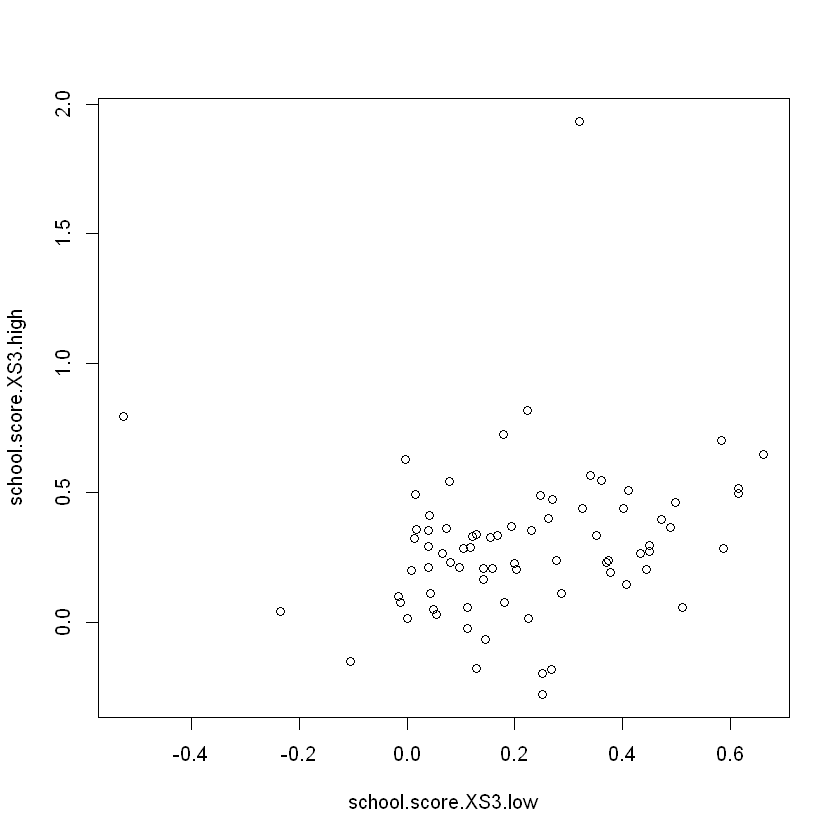

In [95]:
plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)

## Look at school-wise heterogeneity

Discover heterogeneity in X1 (wise). On the other hand, there is no heterogeneity in X2 (Achievement at school). Having Mixed results in X1 and X2 are covariates of school level.

In [96]:
pdf("school_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()


png 
  2

In [33]:
#
# Re-check ATE... sanity check only
#


In [97]:
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.248 +/- 0.039"


In [35]:
#
# Look at variation in propensity scores
#

In [98]:
DF = X
DF$W.hat = cf$W.hat

In [99]:
pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()

png 
  2

## Analysis ignoring clusters. How do the results change?

If we train the causal forest on students without clustering by school, then we obtain marked differences from the previous results.
The confidence interval for the ATE is now markedly half of the previous exercise and there appears to be an ambiguous heterogeneous effect according to the test_calibatrion function.

In [100]:
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

In [101]:
ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

[1] "95% CI for the ATE: 0.254 +/- 0.022"

In [102]:
test_calibration(cf.noclust)



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.014372   0.045172  22.456 < 2.2e-16 ***
differential.forest.prediction 0.534271   0.132375   4.036 2.738e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


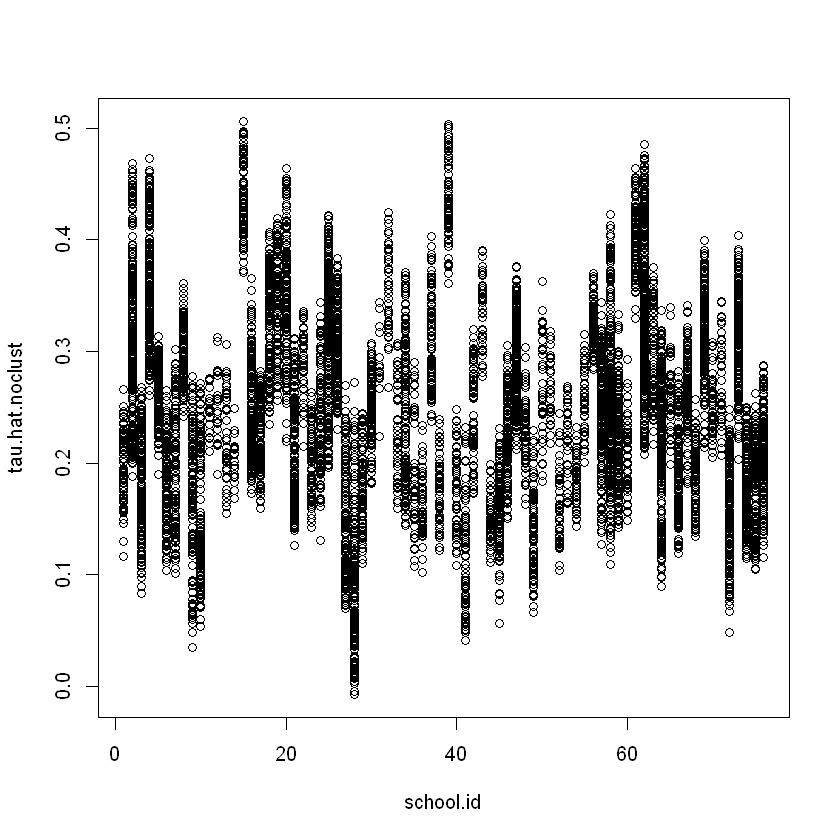

In [103]:
tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)


In [104]:
nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

In [105]:
tau.hat.crossfold = rep(NA, length(Y))


In [106]:
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


In [107]:
cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value  Pr(>t)    
mean.forest.prediction         1.009952   0.065094 15.5153 < 2e-16 ***
differential.forest.prediction 0.458118   0.245527  1.8659 0.03105 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [108]:
Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

In [109]:
c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)


[1] -0.0000220815  0.0001425884

In [110]:
summary(aov(dr.score ~ factor(school.id)))


                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    201   2.678   1.982 1.02e-06 ***
Residuals         10315  13935   1.351                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


# Analaysis without fitting the propensity score
#
Si entramos el modelo sin considerar el propensity score. El resultado da las mismas estimaciones 
que al usar el proceso  de orogonalización.

In [111]:
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)

In [112]:
tau.hat.noprop = predict(cf.noprop)$predictions


In [113]:
ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))


[1] "95% CI for the ATE: 0.254 +/- 0.039"

In [114]:
pdf("tauhat_noprop.pdf")


pdf 
  3

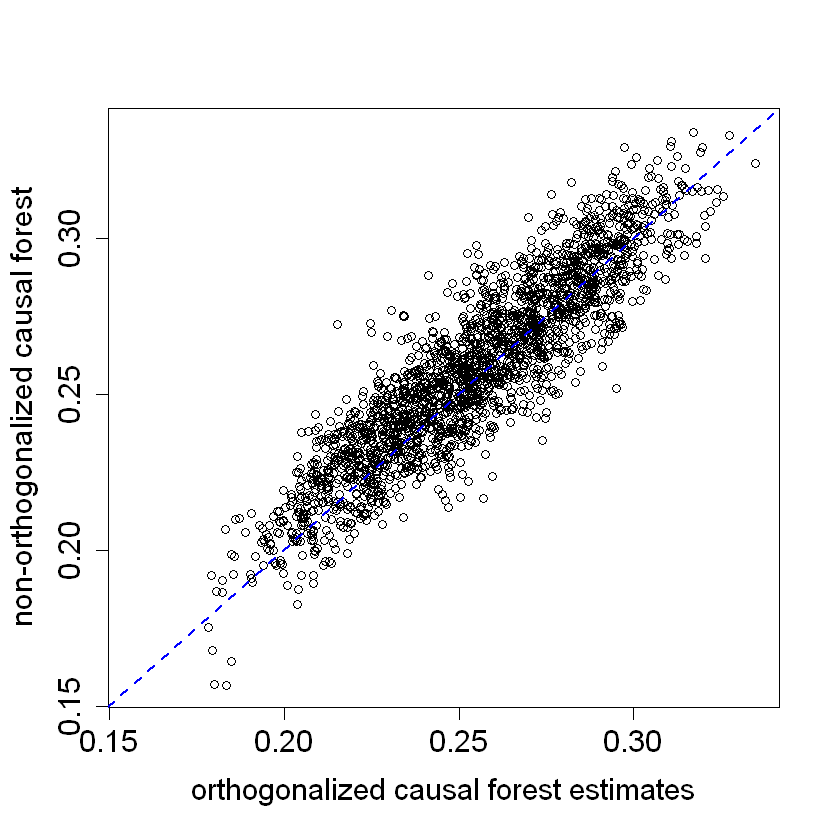

In [115]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

In [ ]:
#
# Train forest on school-wise DR scores
#

In [116]:
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

In [117]:
dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size


In [118]:
school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.999512   0.081949  12.197 <2e-16 ***
differential.forest.prediction 0.680739   0.655182   1.039 0.1511    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [119]:
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2412696  0.0771218  3.1284 0.002616 **
X1          -0.0504144  0.0291605 -1.7289 0.088509 . 
X2           0.0127667  0.0336429  0.3795 0.705552   
X3           0.0104740  0.0266411  0.3932 0.695474   
X4           0.0235292  0.0255123  0.9223 0.359748   
X5          -0.0357527  0.0269103 -1.3286 0.188559   
XC.1         0.0013382  0.0937302  0.0143 0.988652   
XC.2         0.0884114  0.1049088  0.8427 0.402415   
XC.3        -0.1346624  0.0876731 -1.5360 0.129329   
XC.4         0.0424256  0.0816214  0.5198 0.604952   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


## Make some plots

##1
For the first graph we observe that the distribution of the CATE efects are different.

In [139]:
pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

png 
  2

#2
For this graph we observe that the distribution for non prop, the CATE efects are different, but now concentrated in a larger magnitude.

In [140]:
pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()


png 
  2

In [163]:
pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
     breaks = seq(-0.0, 0.55, by = 0.55 / 25))
dev.off()

ERROR: Error in hist.default(tau.hat.noclust, xlab = "estimated CATE", main = "", : some 'x' not counted; maybe 'breaks' do not span range of 'x'


#4
The following graph shows the Student's CATE estimates against school-level minset X1.

In [144]:
pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

png 
  2

#5
The following graph shows the Student's CATE estimates against school-achievement level X2.

In [146]:
pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()


png 
  2

#6

The following graph shows us the relationship between the predictions at the school level using covariates and the mean estimates of the CATE at the school, it can be seen that there is a positive relationship. Higher predictions of achievement measures are then found when the mean CATE estimate in a school is also higher.

In [147]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size


In [148]:
pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()


png 
  2

In [ ]:
#
# Experiment with no orthogonalization
#

In [164]:
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)


In [165]:
Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions


In [166]:
cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

[1] "95% CI for the ATE: 0.021 +/- 0.151"

In [167]:
cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: 0.135 +/- 0.14"


## Visualize school-level covariates by treatment heterogeneity


In [168]:
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

In [169]:
MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

In [170]:
DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))


## tercile_plot
It can be seen that there is a difference for X1, while for the other covariates, not much difference is found. There is also a difference between the low and high group of CATEs. 

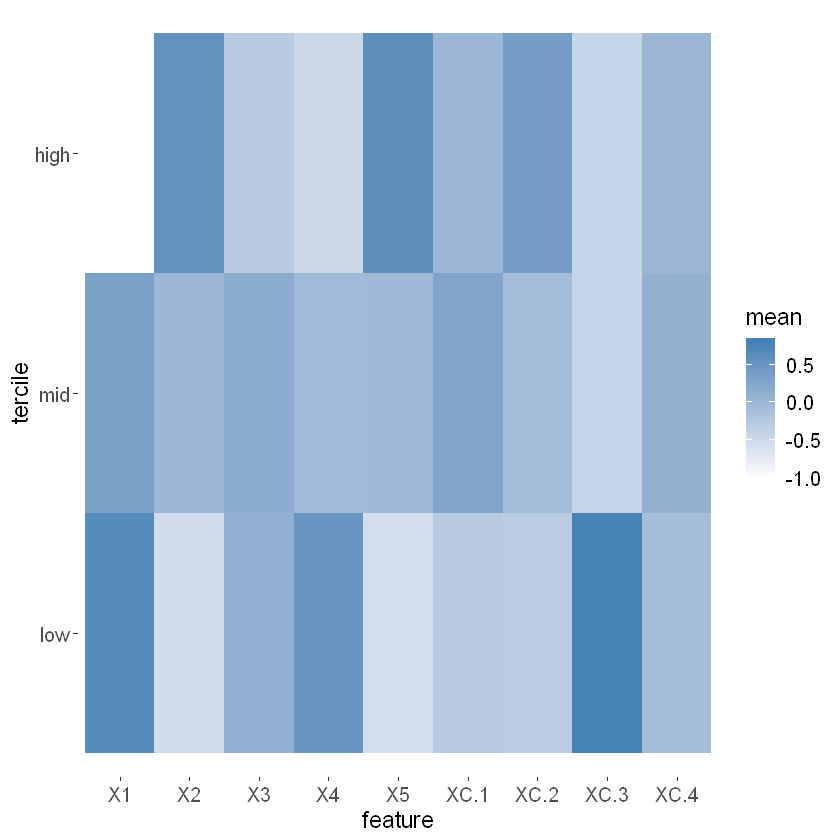

In [171]:
ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

In [172]:
mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

[1] 0.2105263

[1] 0.5384615

## CATE by school

When clusters are ignored, the CATE is higher and more dispersed by school than when clusters are used. 

In [173]:
ord = order(order(school.pred))
school.sort = ord[school.id]

In [174]:
pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()

png 
  2